## Inicialización

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

labels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [2]:
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=True
)


Found 7591 validated image filenames.


## EDA

In [3]:
labels['real_age'].describe()


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

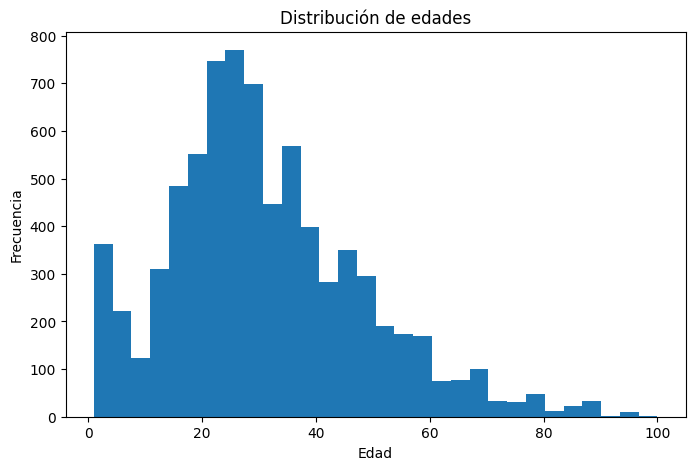

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(labels['real_age'], bins=30)
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Distribución de edades')
plt.show()


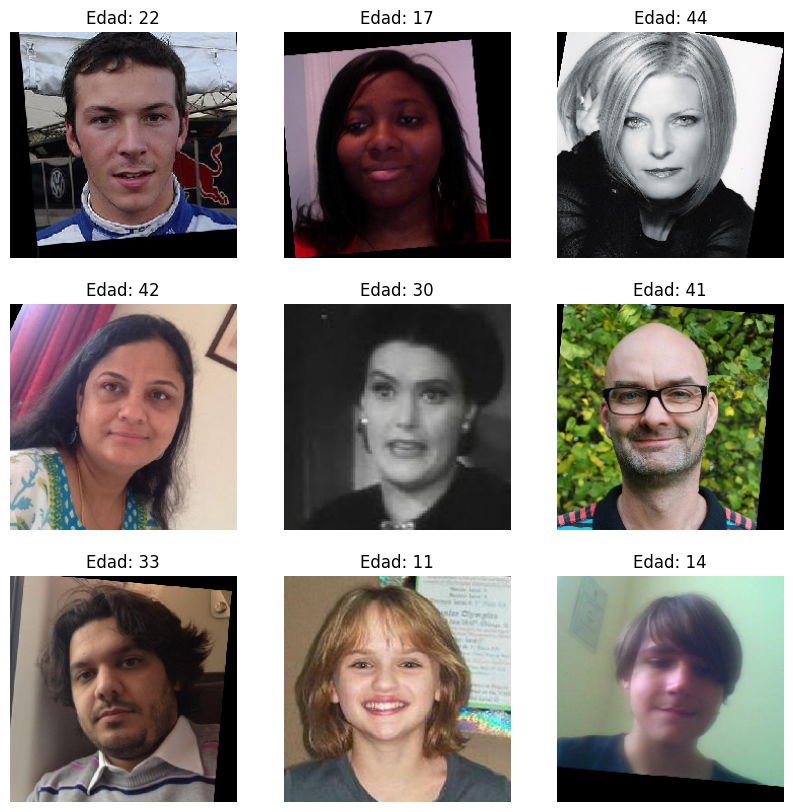

In [5]:
import matplotlib.pyplot as plt
import numpy as np

images, ages = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Edad: {int(ages[i])}')
    plt.axis('off')
plt.show()


### Conclusiones

El conjunto de datos contiene imágenes reales y variadas, lo que es positivo para la generalización del modelo.

La variable real_age presenta una distribución desigual, con mayor presencia de adultos jóvenes.

Existen factores visuales (iluminación, pose, expresión) que pueden introducir ruido en la predicción.

El uso de un modelo de regresión con redes convolucionales es adecuado para esta tarea.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [6]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )
    
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        shuffle=True
    )

    return train_gen_flow


In [10]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        shuffle=False
    )

    return test_gen_flow


In [7]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    
    backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )

    return model

In [8]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model


### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [12]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

## Conclusiones

# Lista de revisión

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [ ]  El valor EAM del modelo no es superior a 8
- [ ]  El código de entrenamiento del modelo se copió en el notebook final
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final
- [ ]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo